# Process MRI mouse brain

## Save nii

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk

if False:
    data = np.load('data/degu_191.npy')
    atlas_data = np.load('data/waxholm.npy')
    atlas_data_compressed = np.load('data/waxholm_compressed.npy')


    data_nib = nib.Nifti1Image(data, affine=np.eye(4))
    nib.save(data_nib, 'output/degu_191.nii.gz')

    atlas_nib = nib.Nifti1Image(atlas_data, affine=np.eye(4))
    nib.save(atlas_nib, 'output/waxholm.nii.gz')

    atlas_nib_compressed = nib.Nifti1Image(atlas_data_compressed, affine=np.eye(4))
    nib.save(atlas_nib_compressed, 'output/waxholm_compressed.nii.gz')

In [2]:
def plot_points(mpoints, fpoints, section, point_size=8, title=""):
    f = plt.figure(figsize=(8, 8))
    plt.imshow(section, cmap='gray')
    plt.scatter(mpoints[:, 2], mpoints[:, 1], c='green', s=point_size, label='Moving points')
    plt.scatter(fpoints[:, 2], fpoints[:, 1], c='blue', s=point_size, label='Fixed points')
    
    # Draw arrows between corresponding points
    for m_point, f_point in zip(mpoints, fpoints):
        plt.arrow(m_point[2], m_point[1], f_point[2] - m_point[2], f_point[1] - m_point[1],
                  head_width=0.013, head_length=0.013, fc='black', ec='black')
    plt.title(title)
    plt.show()
    
    
def getMutualInformation(fdata, mdata):
    """
    Wrapper function to calculate Mutual information between two numpy arrays usint SITK mutual information
    
    Parameters
    ------------
    fdata: np array
    mdata: np array
    """
    def rescaleMaxTo255(data):
        """
        Thresholds  and converts data to UINT8
        """
        maxVal  = np.percentile(data, 99)
        data[data > maxVal ] = maxVal
        data = data*255 /maxVal
        return data

    mdata[mdata<0] =0
    m8 = rescaleMaxTo255(mdata)
    f8 = rescaleMaxTo255(fdata)
    fImage = sitk.GetImageFromArray(f8.astype(float))
    mImage = sitk.GetImageFromArray(m8.astype(float))
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation()
    return registration_method.MetricEvaluate(fImage, mImage)

## Load data

In [10]:
# Load data
data = nib.load('output/processed/degu_191.nii.gz').get_fdata()
atlas = nib.load('output/processed/waxholm.nii.gz').get_fdata()
ants_atlas = nib.load('output/registered/ants_atlas_to_degu_191.nii.gz').get_fdata()
registered_output = nib.load('output/registered/atlas_to_degu_laplacianRefined_external.nii.gz').get_fdata()
registered_output_internal = nib.load('output/registered/atlas_to_degu_laplacianRefined_internal.nii.gz').get_fdata()

print("Data shape:", data.shape)

Data shape: (592, 288, 464)


In [117]:
CURR_IDX = 360  # 360

# Load points
mpoints = np.load('output/degu_mpoints.npy')
fpoints = np.load('output/degu_fpoints.npy')

print("Number of moving points: ", mpoints.shape[0])
print("Number of fixed points: ", fpoints.shape[0])

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]
mpoints[:, 0] = 0
fpoints[:, 0] = 0

print(f"Number of moving points in {CURR_IDX}: ", mpoints.shape[0])
print(f"Number of fixed points in {CURR_IDX}: ", fpoints.shape[0])

Number of moving points:  170012
Number of fixed points:  170012
Number of moving points in 360:  634
Number of fixed points in 360:  634


In [ ]:
# 60, 180, 245, 280, 340
plot_points(mpoints, fpoints, data[CURR_IDX], title=f"Moving image (slice {CURR_IDX*2})")
plot_points(mpoints, fpoints, atlas_compressed[CURR_IDX], title=f"Fixed image (slice {CURR_IDX*2})")



NameError: name 'mpoints' is not defined

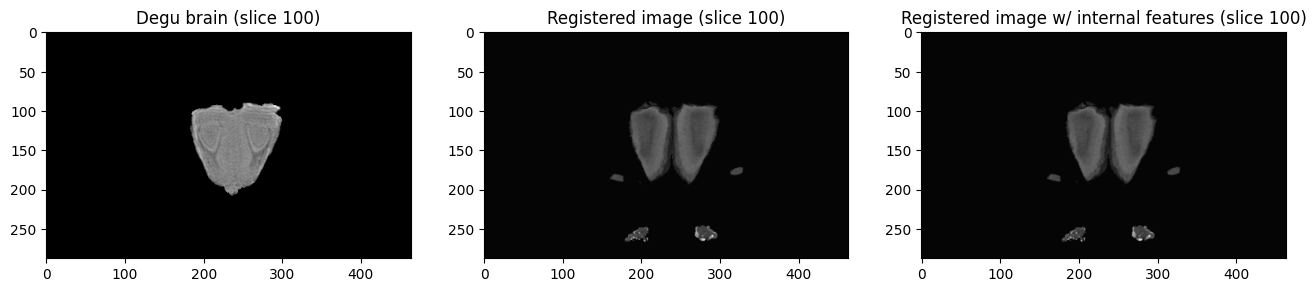

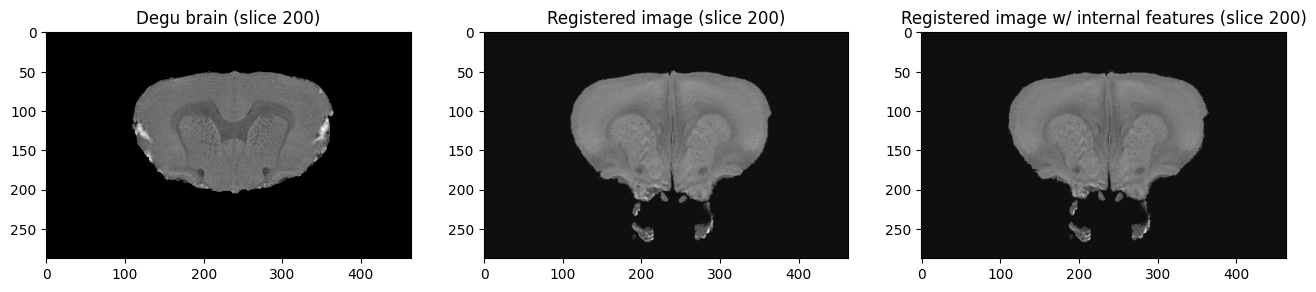

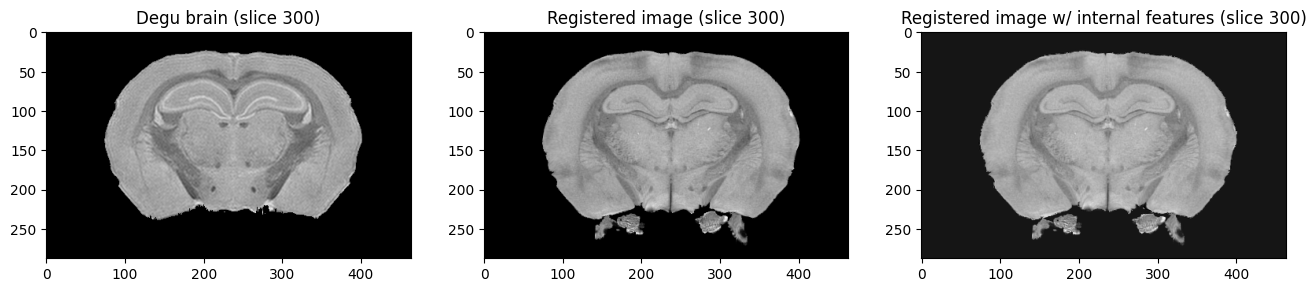

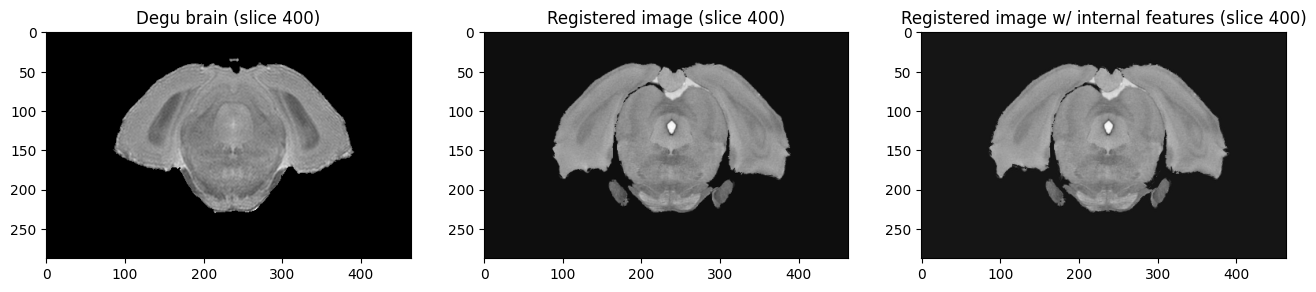

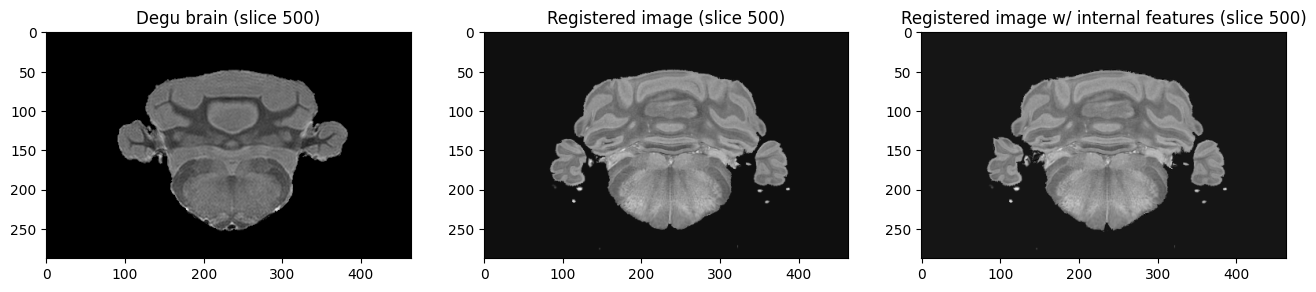

In [7]:
CURR_IDX = 100

def plot_slices(idx, data, registered_output, registered_output_internal):
    f, ax = plt.subplots(1, 3, figsize=(16, 8))
    ax[0].imshow(data[idx], cmap='gray')
    ax[0].set_title(f"Degu brain (slice {idx})")
    ax[1].imshow(registered_output[idx], cmap='gray')
    ax[1].set_title(f"Registered image (slice {idx})")
    ax[2].imshow(registered_output_internal[idx], cmap='gray')
    ax[2].set_title(f"Registered image w/ internal features (slice {idx})")
    plt.show()
    plt.close(f)
    
plot_slices(100, data, registered_output, registered_output_internal)
plot_slices(200, data, registered_output, registered_output_internal)
plot_slices(300, data, registered_output, registered_output_internal)
plot_slices(400, data, registered_output, registered_output_internal)
plot_slices(500, data, registered_output, registered_output_internal)

In [11]:
ants_mutual = getMutualInformation(data, ants_atlas)
registered_mutual = getMutualInformation(data, registered_output)
registered_mutual_internal = getMutualInformation(data, registered_output_internal)

print("Mutual information between Degu and ANTs atlas-to-Degu registered data: ", ants_mutual)
print("Mutual information between Degu and ANTs + Laplacian data (with external features only): ", registered_mutual)
print("Mutual information between Degu and ANTs + Laplacian data (with internal features): ", registered_mutual_internal)

Mutual information between Degu and ANTs atlas-to-Degu registered data:  -0.45598886952283857
Mutual information between Degu and ANTs + Laplacian data (with external features only):  -0.466488760977536
Mutual information between Degu and ANTs + Laplacian data (with internal features):  -0.46582915618833626


In [92]:
ants_mutual = getMutualInformation(atlas_compressed[100:360, :, :], data[100:360, :, :])
registered_mutual = getMutualInformation(atlas_compressed[100:360, :, :], registered_output[100:360, :, :])

print("Mutual information between atlas and ANTs registered data: ", ants_mutual)
print("Mutual information between atlas and ANTs + Laplacian data: ", registered_mutual)

Mutual information between atlas and ANTs registered data:  -0.5011646392778054
Mutual information between atlas and ANTs + Laplacian data:  -0.504827630419338
